Задание №25

Используя предобученные нейронные сети для задачи классификации изображений, решить задачу регрессии для отыскания возраста человека, изображенного на снимке.

Анализ и план работы: <br>
Загружаем данные из предварительно очищенного и обработанного датасета wiki_crop (обработка снимков производится отдельным файлом) <br>
Загружаем предобученную сеть EfficientNet. Изменяем последний слой для выдачи решения задачи регрессии <br>
Обучаем сеть, контролируя качество обучения с помощью валидационной выборки, функция качества RMSE определения возраста <br>
Строим графики <br>
Проверяем метрики на тестовом наборе <br>
Делаем выводы

1. Loading necessary modules:

In [87]:
%reset -f 

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os, re, cv2
from datetime import datetime

In [88]:
dtype = torch.float # speeding up on the GPU

2. CUDA enable (pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118)

In [89]:
print(f'CUDA is available: {torch.cuda.is_available()}')       # True
if torch.cuda.is_available():
    print(f'Device count: {torch.cuda.device_count()}')        # 1
    print(f'Current device #: {torch.cuda.current_device()}')  # 0
    print(f'GPU name: {torch.cuda.get_device_name(0)}') 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

CUDA is available: False
Device: cpu


3. Loading the data (pre-processed images) and corresponding ages of people

In [90]:
batch_size = 16

# Custom Dataset for loading images, and age calculation
class AgeDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.image_paths = []
        self.ages = []

        # Loading images, calculating the age
        for file_name in os.listdir(folder):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Extracting date of birth and the year of photo taking
                match = re.search(r'_(\d{4})-(\d{2})-(\d{2})_(\d{4})', file_name)
                if match:
                    birth_year = int(match.group(1))
                    birth_month = int(match.group(2))
                    birth_day = int(match.group(3))
                    if birth_day == 0: # sometimes in the dataset we have zeroth date of birth
                        birth_day = 1
                    shoot_year = int(match.group(4))
                    # print(f'Y: {birth_year}, M: {birth_month}, D: {birth_day}, Shoot: {shoot_year}')
                    # Age calculation:
                    birth_date = datetime(birth_year, birth_month, birth_day)
                    shoot_date = datetime(shoot_year, 7, 1)  # Say the photo is taken on the 1st of July (middle of the year)
                    age = (shoot_date - birth_date).days // 365  # Age in years
                    
                    self.image_paths.append(os.path.join(folder, file_name))
                    self.ages.append(age)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        age = self.ages[idx]
        image_bgr = cv2.imread(image_path)  # Load image 
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # convert to RGB

        if self.transform:
            image_rgb = self.transform(image_rgb)  # Transform to pytorch tensor; also normalize

        return image_rgb, torch.tensor(age, dtype=torch.float32)

# Folder with the images prepared
folder = 'wiki_crop_cleaned'

# Transforms for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalizing images
])

# Creating the Dataset
dataset = AgeDataset(folder, transform=transform)

# Splitting the Dataset into traning, validation and the test one
train_size = int(0.7 * len(dataset))  # 70% for the train
val_size = int(0.15 * len(dataset))   # 15% for the validation
test_size = len(dataset) - train_size - val_size  # the rest 15% for the test 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# saving datasets for reproducible stop and rerun of the neural network training

# Save indices to corresponding variables
train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices

4. Initializing the EfficientNet model (and loading the previosly saved state if any)

In [91]:
# Loading the pretrained model

model = models.efficientnet_b0(pretrained=True)  

# Replacing the last layer with the classifier having the single output
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # one output for regression to age

# Optimizer and loss function 
criterion = nn.MSELoss()  # mean squared error of the age prediction for loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Decreasing learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Trying to read the saved checkpoint to restore models state for keeping on the training
try:
    checkpoint = torch.load('checkpoint_efficientnet.pth')
    model.load_state_dict(checkpoint['model_state_dict']) # load model state       
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Move optimizer to the device being used
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    train_loss_values = checkpoint['train_loss_values']
    val_rmse_values = checkpoint['val_rmse_values']
    current_epoch = checkpoint['epoch'] 
    train_indices = checkpoint['train_indices']
    val_indices = checkpoint['val_indices']
    test_indices = checkpoint['test_indices']
except:
    current_epoch = 1        
    train_loss_values = []
    val_rmse_values = []
    print('No checkpoint loaded')
    
# Trying to read the saved best model checkpoint to extract the best validation accuracy reached
try:
    checkpoint_best = torch.load('best_model_efficientnet.pth')
    best_rmse =  checkpoint_best['best_rmse']  
except:
    best_rmse = 100     
    print('No best model loaded')
    
# Move the model to GPU if available, otherwise to CPU
model = model.to(device)

c:\Users\varaksa_yua\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\varaksa_yua\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\varaksa_yua\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\varaksa_yua\AppData\Local\Temp\ipykernel_124

4a. Recreate Datasets and DataLoaders in accordance with the indices loaded from the saved checkpoint, if any

In [92]:
# This is done for the dataloaders to be identical at each file run
# (additionally, this changes nothing of no checkpoint is loaded, 
# otherwise it restores datasets and dataloader used at previously stage of training)

# Recreate subsets using Subset
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Recreate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

5. Model training

In [93]:
epochs = 15

while current_epoch <= epochs:
    print(f'Epoch [{current_epoch}/{epochs}]')
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(-1,1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss/len(train_loader)
    print(f'Loss: {average_loss}')
    train_loss_values.append(average_loss) # appending new value of average loss
    
   
    model.eval()
    # evaluation on the validation dataset
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            mse = torch.mean((outputs - labels) ** 2)
            rmse = torch.sqrt(mse).item()            
  
    print(f'Validation RMSE: {rmse:.2f} years')
    val_rmse_values.append(rmse)
    
    # Keep the best model if validation accuracy improves
    if rmse <= best_rmse:
        print(f"Best RMSE: {best_rmse:.2f}")        
        best_rmse = rmse        
        torch.save({'model_state_dict': model.state_dict(),  # model weights
                    'best_rmse' : best_rmse}, 
                   'best_model_efficientnet.pth')
        print(f"New best model saved with RMSE: {best_rmse:.2f} years")   

    # Decreasing the learning rate
    scheduler.step(rmse)
    
    current_epoch += 1

Epoch [11/15]
Loss: 25.415596924375816
Validation RMSE: 17.89 years
Epoch [12/15]
Loss: 21.417193630117662
Validation RMSE: 18.37 years
Epoch [13/15]
Loss: 21.932727171272827
Validation RMSE: 16.99 years
Best RMSE: 17.16
New best model saved with RMSE: 16.99 years
Epoch [14/15]
Loss: 18.25633975062027
Validation RMSE: 18.28 years
Epoch [15/15]
Loss: 20.826283498797075
Validation RMSE: 17.82 years


6. Saving the current state of the model (so-called checkpoint)

In [94]:
# Save model weights and additional information like optimizer state, epoch, etc.
try:
    torch.save({
        'epoch': current_epoch,
        'model_state_dict': model.state_dict(),  # model weights
        'optimizer_state_dict': optimizer.state_dict(), # optimizer   
        'train_loss_values' : train_loss_values,
        'val_rmse_values' : val_rmse_values,
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices 
        }, 'checkpoint_efficientnet.pth')
except:
    print('Error. No current model saved')

7. Evaluation of the current model on the test dataset

In [95]:
# evaluation of the current model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        mse_test = torch.mean((outputs - labels) ** 2)
        rmse_test = torch.sqrt(mse_test)
    
print(f'Test RMSE for the current model: {rmse_test:.2f} years')   

Test RMSE for the current model: 19.54 years


8. Training plots 

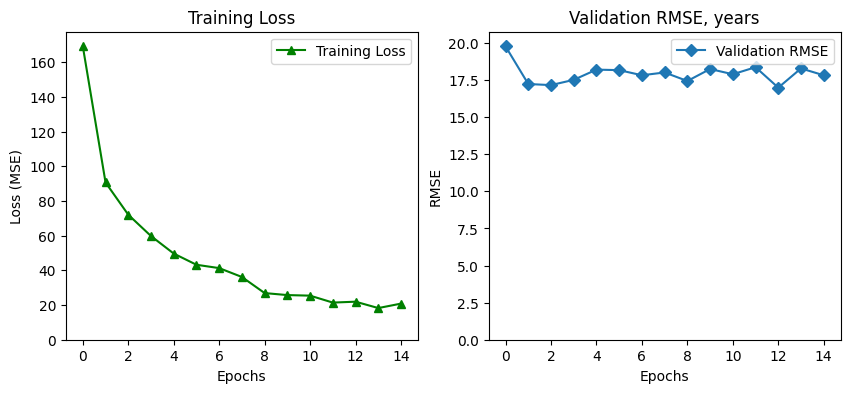

In [96]:
import matplotlib.pyplot as plt

# Learning plots

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_values, 'g-^', label='Training Loss') # 'g^-' - green triangles + solid line
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.legend()
plt.axis([-0.05*epochs, 1.05*epochs-1, 0, 1.05*max(train_loss_values)])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_rmse_values, 'D-', label = 'Validation RMSE') # 'D-' diamonds + solid line
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Validation RMSE, years')
plt.legend()
plt.axis([-0.05*epochs, 1.05*epochs-1, 0, 1.05*max(val_rmse_values)])

plt.show()

9. Loading the best model (i.e. showing the best metrics on the validation dataset)

In [97]:
try:
    checkpoint_best = torch.load('best_model_efficientnet.pth', map_location=torch.device(device.type)) # loads model with mapping the storages to the CPU/GPU if any
    model.load_state_dict(checkpoint_best['model_state_dict']) # load model state
    tmp = checkpoint_best['best_rmse']     
    print(f'Best validation RMSE reached: {tmp:.2f}')
    model.eval() # switch the loaded model to the evaluation mode    
except:
    print('Error. No best model found')

Best validation RMSE reached: 16.99


C:\Users\varaksa_yua\AppData\Local\Temp\ipykernel_12420\3686907239.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_best = torch.load('best_model_efficientnet.

10. Final evaluation of the best model on the test dataset 

In [98]:
# evaluation of the best model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        mse_test = torch.mean((outputs - labels) ** 2)
        rmse_test = torch.sqrt(mse_test)
    
print(f'Test RMSE for the best model: {rmse_test:.2f} years')   

Test RMSE for the best model: 19.64 years


**Выводы:** <br>
На основе предобученной нейронной сети EfficientNet произведено решение задачи регрессии на предварительно обработанных снимках из датасета wiki_crop для определения возраста персонажа на снимках <br>
Достигнутая точность решения задачи регрессии (а именно, среднеквадратичное отклонение найденного возраста от истинного) на тестовой выборке составила: <br> 

19.15 г. (5 эпох) <br>
19.15 г. (10 эпох, лучшей модели по сравнению с предыдущим циклом не найдено) <br>
19.64 г. (15 эпох, модель оказалась лучшей на валидационном наборе, но не на тестовом) <br>

Полученное значение среднеквадратичного разброса возраста выглядит как-то великовато. <br>
Да и не сказать, чтобы модель сильно обучилась. На графике изменения лучшей валидационной среднеквадратичной ошибки видно, что она почти не меняется. <br>

Впрочем, качество исходных данных тоже не назвать очень хорошим. <br>
Количество тоже небольшое - мы используем в обучающем наборе 70% от 25 тысяч фоток, то есть 17 500 изображений. И это при том, что, например, в базе данных рукописных цифр MNIST в обучающем наборе 60 тысяч фоток рукописных цифр. То есть там задача гораздо более простая, но датасет намного больше. Поэтому плохое качество полученного здесь результата не должно удивлять. <br>

